# Propagation of coupled translational-rotational dynamics

## Objectives

The present example will demonstrate the use of a multi-type propagator in Tudat. For that, we will consider the problem of simulating the coupled translational-rotational dynamics of Phobos around Mars, including the definition of a realistic initial state. Let's begin by talking about the forces and torques that we'll be considering as part of our dynamical problem.

## Phobos' dynamics in the Martian system
Due to the relative complexity of this example, it is useful to provide the explicit equations of motion. More details can be found in the [Tudat mathematical model description](https://github.com/tudat-team/tudat-space/raw/master/Tudat_mathematical_model_definition.pdf), and a number of sources in literature, most notably:

* [Rambaux et al. (2012).](https://www.aanda.org/articles/aa/abs/2012/12/aa19710-12/aa19710-12.html) Rotational motion of Phobos. Astronomy & Astrophysics, 548, A14.
* [Jacobson, R. A. (2010)](https://iopscience.iop.org/article/10.1088/0004-6256/139/2/668/meta) The orbits and masses of the Martian satellites and the libration of Phobos. The Astronomical Journal 139.2:668.
* [Jacobson, R. A., and V. Lainey. (2014)](https://www.sciencedirect.com/science/article/abs/pii/S003206331300144X) Martian satellite orbits and ephemerides. Planetary and space science 102 (2014): 35-44.
* [Le Maistre, S. et al. (2019)](https://www.sciencedirect.com/science/article/abs/pii/S0019103518304019). Signature of Phobos’ interior structure in its gravity field and libration. Icarus, 321, 272-290.

The equations we will use here for the translational and rotational dynamics are:

\begin{equation}
\frac{\text{d}\vec v}{\text{d}t}=(\mu_{\text{M}}+\mu_{\text{P}}) \left(-\frac{\vec r}{r^3}+\frac{1}{\mu_{\text{M}}}\mathbf{R^{\mathcal{I/M}}}\nabla_{\mathcal M}U_{\text{M}}(\vec\rho_M^{\ P}) - \frac{1}{\mu_{\text{P}}}\mathbf{R^{\mathcal{I/P}}}\nabla_{\mathcal P}U_{\text{P}}(\vec\rho_P^{\ M})\right) - \sum_{i=1}^N\mu_i\left(\frac{\vec r_{iP}}{r_{iP}^3}-\frac{\vec r_i}{r_i^3}\right)
\end{equation}

\begin{equation}
    \mathbf I\frac{\text d\vec\omega}{\text dt} + \vec\omega\times\left(\mathbf I\vec\omega\right) = -M\vec\rho_P^{\ M}\times\left(\mathbf{R^{\mathcal{I/P}}}\nabla_{\mathcal P}U_{\text{P}}(\vec\rho_P^{\ M})\right) - \sum_{i=1}^NM_i\vec\rho_P^{\ i}\times\left(\mathbf{R^{\mathcal{I/P}}}\nabla_{\mathcal P}U_{\text{P}}(\vec\rho_P^{\ i})\right)
\end{equation}

where:

- Subindices/superindices $P$, $M$ and $i$ refer to Phobos, Mars and the $i$-th third body. Superindex $I$ refers to an _inertial_ reference frame.
- $\vec r_{AB}$ is a _position_ vector going from body A to body B. No subindices mean the vector goes from Mars to Phobos.
- $\vec\rho_A^B$ is a vector going from A to B and expressed in the vector basis attached to the reference frame of body A.
- $\vec v$ is the velocity vector of Phobos.
- $\vec\omega$ is the angular velocity vector of Phobos, expressed in Phobos' reference frame.
- $\mathbf I$ is the inertia tensor of Phobos.
- $\mu_A$ is the gravitational parameter of body A.
- $\mathbf{R^{\mathcal{A/B}}}$ is the rotation matrix from frame $\mathcal B$ to frame $\mathcal A$.
- $\nabla_{\mathcal A}$ represents the gradient operator taken with respect to the coordinates associated to reference frame $\mathcal A$.
- $U_A$ is the gravitational potential generated by body A, usually expanded in terms of spherical harmonic coefficients.
- $M_A$ is the mass of body A.

As you can see, our example simulation will include the following accelerations/torques:

- Mutual spherical harmonic acceleration between Mars and Phobos. Mars' gravity field will be expanded to D/O 10/10, while Phobos' will be expanded to D/O 4/4.
- Third body forces will include those of the Sun, the Earth, Deimos and Jupiter.
- The torque that the center of mass of Mars exerts on Phobos' gravity field.
- The torque exerted on Phobos' gravity field by these bodies: the Sun, the Earth, Deimos and Jupiter (the same bodies as in the accelerations).

## Where is each term defined in Tudat?
When implementing the dynamics in tudat, it is important to be specific in the environment models that we need in order to integrate the equations. In this case, the full state of Phobos will be propagated, so its position, velocity, orientation and angular velocity are **all** propagated states. As an example, in a simple translational propagation, the orientation and angular velocity are given by the **environment** through the body's _rotation model_. In this coupled propagation, the environment will have to define:

- The gravity field of all bodies (either spherical harmonic gravity field or central gravity field).
- A rotation model for Mars.
- The _ephemeris_ of all third bodies.
- The inertia tensor of Phobos.

For most of these, we will use the defaults provided by spice. For Phobos, however, we will create it ourselves from scratch, since the default settings (point mass gravity field; no inertia tensor) are insufficient for our purposes.

## Import statements
As usual at the beginning of a script, we have the import statements. These are all the packages we will need for this example application. We include here the loading of the standard spice kernels.

In [1]:
# IMPORTS
import numpy as np
from numpy import pi as PI
from numpy.fft import rfft, rfftfreq
from numpy.polynomial.polynomial import polyfit
from tudatpy.util import result2array
from tudatpy.interface import spice
from tudatpy import constants, numerical_simulation
from tudatpy.astro.time_conversion import DateTime
from tudatpy.numerical_simulation import environment_setup, propagation_setup
from tudatpy.astro.element_conversion import rotation_matrix_to_quaternion_entries
from tudatpy.astro.frame_conversion import inertial_to_rsw_rotation_matrix
from matplotlib import pyplot as plt

spice.load_standard_kernels()

## Auxiliary functions
In order to keep the main code neat and clean, several auxiliary functions will be used that need to be defined before the main code. Feel free to skip them now and come back to them when they are used in the script.
### Gravitational field definition
Tudat's environment defaults don't include much information about Phobos, so we will have to create it ourselves from scratch. Part of this process is assigning Phobos a gravitational field, which takes a few lines. Thus, the corresponding code will be separated from the main script into the function below.

In [2]:
def get_gravitational_field(frame_name: str) -> environment_setup.gravity_field.GravityFieldSettings:

    """Retrieve Phobos gravity field settings
    This function returns gravity fields settings for Phobos' gravity field, with
    coefficients taken from Le Maistre et al. 2019.

    Parameters
    ----------
    frame_name: str
        Name of the Phobos-fixed reference frame to which to fix the gravity field

    Returns
    -------
    settings_to_return : GravityFieldSettings
        Gravity field settings for Phobos
    """

    phobos_gravitational_parameter = 1.06e16*constants.GRAVITATIONAL_CONSTANT
    phobos_reference_radius = 14e3

    # [TODO: check if coefficients are from Le Maistre ... ... DONE]
    phobos_normalized_cosine_coefficients = np.array([[ 1.0,       0.0,       0.0,      0.0,       0.0     ],
                                                      [ 0.0,       0.0,       0.0,      0.0,       0.0     ],
                                                      [-0.029243,  0.000084,  0.015664, 0.0,       0.0     ],
                                                      [-0.002222, -0.002450,  0.004268, 0.000917,  0.0     ],
                                                      [ 0.002693, -0.001469, -0.000920, 0.001263, -0.000032]])
    phobos_normalized_sine_coefficients = np.array([[0.0, 0.0,       0.0,       0.0,      0.0],
                                                    [0.0, 0.0,       0.0,       0.0,      0.0],
                                                    [0.0, 0.000072, -0.000020,  0.0,      0.0],
                                                    [0.0, 0.001399, -0.000537, -0.006642, 0.0],
                                                    [0.0, 0.000402, -0.000555, -0.001218, 0.000088]])
    settings_to_return = environment_setup.gravity_field.spherical_harmonic(
        phobos_gravitational_parameter,
        phobos_reference_radius,
        phobos_normalized_cosine_coefficients,
        phobos_normalized_sine_coefficients,
        associated_reference_frame = frame_name)

    return settings_to_return

### Initial rotational state generation
The numerical propagation of the rotational dynamics requires an initial state (rotation quaternion and angular velocity vector). We assume that Phobos is in synchronous rotation around Mars, meaning that Phobos' $x$ axis points towards the planet, its $z$ axis is parallel to the orbital angular momentum vector and the $y$ axis completes the right-handed basis (similar to the axes along its RSW frame, with only a flipping of signs). The angular velocity is expressed in body-fixed axes, which makes its definition much easier: we only define non-zero angular velocity about the z-axis. The creation of a rotational state with these characteristics is given in the function below.

In [3]:
def get_initial_rotational_state_at_epoch(epoch: float, rotational_rate_around_z_axis: float) -> np.ndarray:

    """Retrieve Phobos initial rotational state (from fully locked model)
    This function returns the Phobos initial state by specifying that its
    body-fixed x-axis points towards Mars' center of mass (with its state
    from Spice), and a user-defined value for its angular velocity

    Parameters
    ----------
    epoch: float
        Epoch at which to compute initial rotational state

    rotational_rate_around_z_axis: float
        The angular velocity of the body about its z axis.

    Returns
    -------
    np.array
        Vector of initial rotational state (quaternion and angular velocity)
    """

    translational_state = spice.get_body_cartesian_state_at_epoch('Phobos', 'Mars', 'J2000', 'None', epoch)
    synchronous_rotation_matrix = inertial_to_rsw_rotation_matrix(translational_state).T
    synchronous_rotation_matrix[:,:2] = -1.0*synchronous_rotation_matrix[:,:2]
    phobos_rotation_quaternion = rotation_matrix_to_quaternion_entries(synchronous_rotation_matrix)

    angular_velocity = np.array([0.0, 0.0, rotational_rate_around_z_axis])

    return np.concatenate((phobos_rotation_quaternion, angular_velocity))

### Generic logistic functions
There are two functions that will be required in this example but have no direct native implementation (yet):

- Often times, one wants angles to be given in the interval $[0,2\pi)$; other times, one wants the angles in the interval $(-\pi,\pi]$. The `bring_inside_bounds` family of functions below allows the user to select the range in which the elements of an array are to be expressed.
- It is usually of interest to study the frequency components of periodic quantities, like many of those we will encounter in this example. Python provides functions to compute the [fast fourier transform](https://numpy.org/doc/stable/reference/routines.fft.html) of these quantities, but there exists a range of details and subtleties that one has to be aware of. Thus, in order not to bring all these considerations in the middle of our code, we create a function devoted to it. Additional functions required in this process are also defined below.
- To aid in visualization, the longitudinal normal mode of Phobos will be shown in the FFT plots. A function to compute it will be defined.


In [4]:
def bring_inside_bounds(original: float | np.ndarray, lower_bound: float,
                        upper_bound: float, include: str = 'lower') -> float | np.ndarray:

    """This function brings a number inside the given bounds, assuming the interval defined by the bounds can periodically extend the whole real line (e.g. an angle of 9$\pi$ is equivalent to an angle of $\pi$ and at the same time equivalent to an angle of $-\pi$). If a (multidimensional) array is passed, the operation is performed on all its entries. It returns the same object and of the same dimension as it was given.
    *Note:* This function's support of arrays is limited to one-dimensional and two-dimensional arrays.

    Parameters
    ----------
    original: float | np.ndarray
        The original number or array of numbers.

    lower_bound: float
        The lower bound of the periodic interval.

    upper_bound: float
        The upper bound of the periodic interval.

    include: str
        The bound that is to be kept. It can be 'upper' or 'lower'. Anything else will result in an error.

    Returns
    -------
    float | np.array
        The number of array of numbers, all inside the interval.

    """

    if include not in ['upper', 'lower']:
        raise ValueError('(bring_inside_bounds): Invalid value for argument "include". Only "upper" and "lower" are allowed. Provided: ' + include)

    if type(original) in [float, np.float32, np.float64, np.longdouble()]: #np.longdouble replaces np.float128, which might give problems in some architectures
        to_return = bring_inside_bounds_scalar(original, lower_bound, upper_bound, include)
    else:
        dim_num = len(original.shape)

        if dim_num == 1:
            to_return = bring_inside_bounds_single_dim(original, lower_bound, upper_bound, include)
        elif dim_num == 2:
            to_return = bring_inside_bounds_double_dim(original, lower_bound, upper_bound, include)
        else:
            raise ValueError('(bring_inside_bounds): Invalid input array.')

    return to_return


def bring_inside_bounds_single_dim(original: np.ndarray, lower_bound: float,
                                   upper_bound: float, include: str = 'lower') -> np.ndarray:

    """This function brings the entries of a one-dimensional array inside the given bounds, assuming the interval defined by the bounds can periodically extend the whole real line (e.g. an angle of 9$\pi$ is equivalent to an angle of $\pi$ and at the same time equivalent to an angle of $-\pi$). It returns another one-dimensional array.

    Parameters
    ----------
    original: np.ndarray
        The original array.

    lower_bound: float
        The lower bound of the periodic interval.

    upper_bound: float
        The upper bound of the periodic interval.

    include: str
        The bound that is to be kept. It can be 'upper' or 'lower'. Anything else will result in an error.

    Returns
    -------
    np.array
        The array of numbers, all inside the interval.

    """

    new = np.zeros_like(original)
    for idx in range(len(new)):
        new[idx] = bring_inside_bounds_scalar(original[idx], lower_bound, upper_bound, include)

    return new


def bring_inside_bounds_double_dim(original: np.ndarray, lower_bound: float,
                                   upper_bound: float, include: str = 'lower') -> np.ndarray:

    """This function brings the entries of a two-dimensional array inside the given bounds, assuming the interval defined by the bounds can periodically extend the whole real line (e.g. an angle of 9$\pi$ is equivalent to an angle of $\pi$ and at the same time equivalent to an angle of $-\pi$). It returns another two-dimensional array.

    Parameters
    ----------
    original: np.ndarray
        The original array.

    lower_bound: float
        The lower bound of the periodic interval.

    upper_bound: float
        The upper bound of the periodic interval.

    include: str
        The bound that is to be kept. It can be 'upper' or 'lower'. Anything else will result in an error.

    Returns
    -------
    np.array
        The array of numbers, all inside the interval.

    """

    lengths = original.shape
    new = np.zeros_like(original)
    for idx0 in range(lengths[0]):
        for idx1 in range(lengths[1]):
            new[idx0, idx1] = bring_inside_bounds_scalar(original[idx0, idx1], lower_bound, upper_bound, include)

    return new


def bring_inside_bounds_scalar(original: float, lower_bound: float,
                               upper_bound: float, include: str = 'lower') -> float:

    """This function brings a scalar inside the given bounds, assuming the interval defined by the bounds can periodically extend the whole real line (e.g. an angle of 9$\pi$ is equivalent to an angle of $\pi$ and at the same time equivalent to an angle of $-\pi$). It returns another scalar.

    Parameters
    ----------
    original: float
        The original number.

    lower_bound: float
        The lower bound of the periodic interval.

    upper_bound: float
        The upper bound of the periodic interval.

    include: str
        The bound that is to be kept. It can be 'upper' or 'lower'. Anything else will result in an error.

    Returns
    -------
    float
        The number, now inside the interval.

    """

    # EXPLAIN THINGS HERE. MAKE CLEAR WHAT VARIABLES REPRESENT.

    if original == upper_bound or original == lower_bound:
        if include == 'lower':
            return lower_bound
        else:
            return upper_bound

    if lower_bound < original < upper_bound:
        return original

    center = (upper_bound + lower_bound) / 2.0

    if original < lower_bound:
        reflect = True
    else:
        reflect = False

    if reflect:
        original = 2.0 * center - original

    dividend = original - lower_bound
    divisor = upper_bound - lower_bound
    remainder = dividend % divisor
    new = lower_bound + remainder

    if reflect: new = 2.0 * center - new

    if new == lower_bound and include == 'upper':
        new = upper_bound
    if new == upper_bound and include == 'lower':
        new = lower_bound

    return new

# FAST FOURIER TRANSFORM FUNCTIONALITIES
def get_fourier(time_history: np.ndarray, clean_signal: list = [0.0, 0]) -> tuple:

    """This function computes the fast fourier transform of a provided time history. It assumes that the quantity of the time history is real, and calls Numpy's rfft function to compute it. This function complements Numpy's rfft in the following ways:

    - It accounts for a time history with an odd number of entries and removes the last entry to make it of even length.
    - It allows to clean the signal. This encompasses two things:
        - Some quantities present jumps because they are by definition bounded inside an interval, but their evolution is secular. This function removes this jumps and works with a continuous signal.
        - Sometimes one is interested in the residuals of the signal when a predefined polynomial is removed from it. This function allows to remove this polynomial and return the fft of the residuals. The coefficients of the polynomial are computed using Numpy's polyfit.
    - Numpy's rfft returns a complex arrays of coefficients, usually not useful. This function returns the amplitude domain, attending to the fact that (a) the norm of the coefficients is to be taken and (b) the actual amplitude of the sinusoid is twice the norm of the complex coefficient.
    - Numpy's rfftfreq returns a frequency array that is in cycles / unit_of_time. This function returns the frequencies in rad / unit_of_time.

    Parameters
    ----------
    time_history: np.ndarray
        A two-dimensional array with two columns: the first column is the time, the second is the quantity whose frequency content is to be computed.
    clean_signal: list[float]
        This determines (a) whether the signal is to be removed of jumps and (b) whether a polynomial is to be removed from the signal. The first entry of clean_signal is the value of the jumps, and the second entry is the degree of the polynomial.

    Returns
    -------
    tuple
        There are two returns: the array of frequencies (in rad / unit_of_time) and the array of amplitudes.

    """

    if type(clean_signal[1]) != int:
        raise TypeError('(get_fourier): Invalid input. The second entry in clean_signal should be of type "int". A type ' + str(type(clean_signal[1])) + 'was provided.')
    if clean_signal[1] < 0:
        raise ValueError('(get_fourier): Invalid input. The second entry in clean_signal cannot be negative. Current values is ' + str(clean_signal[1]) + '.')
    if clean_signal[0] < 0.0:
        raise ValueError('(get_fourier): Invalid input. The first entry in clean_signal cannot be negative. Current values is ' + str(clean_signal[1]) + '.')

    sample_times = time_history[:,0]
    signal = time_history[:,1]

    if len(sample_times) % 2.0 != 0.0:
        sample_times = sample_times[:-1]
        signal = signal[:-1]

    if clean_signal[0] != 0.0:
        signal = remove_jumps(signal, clean_signal[0])
    if clean_signal[1] != 0:
        coeffs = polyfit(sample_times, signal, clean_signal[1])
        for idx in range(len(coeffs)):
            current_coeff = coeffs[idx]
            exponent = idx
            signal = signal - current_coeff*sample_times**exponent
            idx +=1

    n = len(sample_times)
    dt = sample_times[1] - sample_times[0]
    frequencies = 2.0*PI * rfftfreq(n, dt)
    amplitudes = 2*abs(rfft(signal, norm = 'forward'))

    return frequencies, amplitudes

def remove_jumps(original: np.ndarray, jump_height: float, margin: float = 0.03) -> np.ndarray:

    """This function removes discontinuities from a signal of a quantity that is periodic (like angles), so that a continuous signal is obtained in the end. Since data points are discrete, and it may happen that a jump occurs between two points that are not the **full** length of the jump apart, a margin is used to define how close two points can be while still considering that there is a jump between them. This function supports two-dimensional inputs. Then, each column will be assumed to contain one signal from which the jumps are to be removed.

    The particular mathematics are as follows. Consider a signal contained in an interval of length L, from which a continuous signal is required that extends beyond the bounds of this interval. By definition, the distance between any two points in the signal will be $|x_i - x_j| <= L$. However, if two (consecutive) points meet the condition $mL <  |x_i - x_{i+1}| <= L$ a jump is considered to exist between them and will therefore be removed. Here, $m$ is the user defined margin (the default is 3%).

    Parameters
    ----------
    original: np.ndarray
        The original signal with all the elements between the bounds.

    jump_height: float
        It is the value $L$ as used in the previous explanation.

    margin: float
        It is the value $m$ as used in the previous explanation.

    Returns
    -------
    np.ndarray
        An array of the same shape as the provided one. Each column is now a continuous signal.

    """

    dim_num = len(original.shape)

    if dim_num == 1:
        return remove_jumps_single_dim(original, jump_height, margin)
    elif dim_num == 2:
        return remove_jumps_double_dim(original, jump_height, margin)
    else: raise ValueError('(remove_jumps): Invalid input array.')


def remove_jumps_single_dim(original: np.ndarray, jump_height: float, margin: float = 0.03) -> np.ndarray:

    """This function removes discontinuities from a signal of a quantity that is periodic (like angles), so that a continuous signal is obtained in the end. Since data points are discrete, and it may happen that a jump occurs between two points that are not the **full** length of the jump apart, a margin is used to define how close two points can be while still considering that there is a jump between them. This function is the one-dimensional implementation of *remove_jumps*.

    The particular mathematics are as follows. Consider a signal contained in an interval of length L, from which a continuous signal is required that extends beyond the bounds of this interval. By definition, the distance between any two points in the signal will be $|x_i - x_j| <= L$. However, if two (consecutive) points meet the condition $mL <  |x_i - x_{i+1}| <= L$ a jump is considered to exist between them and will therefore be removed. Here, $m$ is the user defined margin (the default is 3%).

    Parameters
    ----------
    original: np.ndarray
        The original (one-dimensional) signal with all the elements between the bounds.

    jump_height: float
        It is the value $L$ as used in the previous explanation.

    margin: float
        It is the value $m$ as used in the previous explanation.

    Returns
    -------
    np.ndarray
        The continuous signal.

    """

    new = original.copy()
    u = 1.0 - margin
    l = -1.0 + margin
    for idx in range(len(new)-1):
        d = (new[idx+1] - new[idx]) / jump_height
        if d <= l: new[idx+1:] = new[idx+1:] + jump_height
        if d >= u: new[idx+1:] = new[idx+1:] - jump_height

    return new


def remove_jumps_double_dim(original: np.array, jump_height: float, margin: float = 0.03) -> np.ndarray:

    """This function removes discontinuities from a signal of a quantity that is periodic (like angles), so that a continuous signal is obtained in the end. Since data points are discrete, and it may happen that a jump occurs between two points that are not the **full** length of the jump apart, a margin is used to define how close two points can be while still considering that there is a jump between them. This function is the two-dimensional implementation of *remove_jumps*.

    The particular mathematics are as follows. Consider a signal contained in an interval of length L, from which a continuous signal is required that extends beyond the bounds of this interval. By definition, the distance between any two points in the signal will be $|x_i - x_j| <= L$. However, if two (consecutive) points meet the condition $mL <  |x_i - x_{i+1}| <= L$ a jump is considered to exist between them and will therefore be removed. Here, $m$ is the user defined margin (the default is 3%).

    Parameters
    ----------
    original: np.ndarray
        The original (two-dimensional) signal with all the elements between the bounds. Each of the columns of this array is interpreted as an independent signal.

    jump_height: float
        It is the value $L$ as used in the previous explanation.

    margin: float
        It is the value $m$ as used in the previous explanation.

    Returns
    -------
    np.ndarray
        The continuous signal.

    """

    new = original.copy()
    u = 1.0 - margin
    l = -1.0 + margin
    for col in range(new.shape[1]):
        for row in range(new.shape[0]-1):
            d = ( new[row+1,col] - new[row,col] ) / jump_height
            if d <= l: new[row+1:,col] = new[row+1:,col] + jump_height
            if d >= u: new[row+1:,col] = new[row+1:,col] - jump_height

    return new

# NORMAL MODE COMPUTATION
def get_longitudinal_normal_mode_from_inertia_tensor(inertia_tensor: np.ndarray, mean_motion: float) -> float:

    """This function computes the frequency of the longitudinal normal mode of a body from the components of its inertia tensor. The equation is provided in Rambaux, 2012.

    Parameters
    ----------
    inertia_tensor: np.ndarray
        The tensor of inertia of the body.

    mean_motion: float
        The mean motion of the body's orbit.

    Returns
    -------
    float
        The frequency of the longitudinal normal mode of the body (in rad/s).

    """

    # From Rambaux (2012) "Rotational motion of Phobos".

    A = inertia_tensor[0,0]
    B = inertia_tensor[1,1]
    C = inertia_tensor[2,2]
    gamma = (B - A) / C

    return mean_motion * np.sqrt(3*gamma)

## Generating the environment
We will begin by creating our Solar System. We will begin by creating the `body_settings` for all bodies except Phobos. These settings will be used to create the `bodies` object. **Note:** Be aware of the modules you need to import.

In [5]:
# WE CREATE EVERYTHING THAT IS NOT PHOBOS
bodies_to_create = ["Sun", "Earth", "Mars", "Deimos", "Jupiter"]
global_frame_origin = "Mars"
global_frame_orientation = "J2000"  # WATCH OUT! This represents the Earth's equatorial reference frame at the J2000 epoch.
body_settings = environment_setup.get_default_body_settings(bodies_to_create, global_frame_origin, global_frame_orientation)

# AND NOW WE CREATE PHOBOS
body_settings.add_empty_settings('Phobos')
body_settings.get('Phobos').ephemeris_settings = environment_setup.ephemeris.direct_spice('Mars', 'J2000')
body_settings.get('Phobos').rotation_model_settings = environment_setup.rotation_model.synchronous('Mars', 'J2000', 'Phobos_body_fixed')
body_settings.get('Phobos').gravity_field_settings = get_gravitational_field('Phobos_body_fixed')
body_settings.get('Phobos').gravity_field_settings.scaled_mean_moment_of_inertia = 0.43

# AND NOW WE CREATE THE BODIES OBJECT
bodies = environment_setup.create_system_of_bodies(body_settings)

Although both the translation and rotation of Phobos will be numerically integrated, it is advantageous to assign the body object with a-priori ephemeris and rotation models. One might want to access these attributes - for instance to retrieve an initial state - and pre-existing ephemeris and rotation models prevent potential internal inconsistencies within tudat.

Above, we are assigning the `scaled_moment_of_inertia` of Phobos to its `gravity_field_settings`, while no other mention to Phobos' inertia tensor is made when creating this environment. There exists a relationship between the components of the inertia tensor and the degree 2 spherical harmonic coefficients (see the [API reference](https://py.api.tudat.space/en/latest/gravitation.html#tudatpy.astro.gravitation.spherical_harmonic_coefficients_from_inertia) for the `spherical_harmonic_coefficients_from_inertia` function), completed by the scaled mean moment of inertia. When calling the function `create_system_of_bodies()`, Tudat will automatically compute the inertia tensor of Phobos using the information of its gravity field. Thus, information on the inertia tensor has been unified inside the `gravity_field_settings`. Note that, for case where the inertia tensor is defined 'manually' by the user, the attribute `body_settings.get('Phobos').rigid_body_settings` has to be set.

Now that our environment is complete. It is time to start defining the dynamics themselves.

## Coupled dynamics
If you have used Tudat before, you are most probably familiar with what _translational propagators_ are. Possibly, you are also familiar with combined translational-mass propagations. These are just an example of a **multi-type propagation**, and the combined translational-rotational is another example of this multi-type propagation. The way Tudat deals with these multi-type propagations is by creating the appropriate "single-type" propagation settings for each type of dynamics, and then putting them all together at then end in the _multi-type propagator settings_. Thus, we will follow the same process here. For more details, see [multi-type propagation documentation](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/multi_type.html).

As you will see in the code below - and can be deduced comparing the APIs for the [translational](https://py.api.tudat.space/en/latest/propagator.html#tudatpy.numerical_simulation.propagation_setup.propagator.translational), [rotational](https://py.api.tudat.space/en/latest/propagator.html#tudatpy.numerical_simulation.propagation_setup.propagator.rotational) and [multi-type](https://py.api.tudat.space/en/latest/propagator.html#tudatpy.numerical_simulation.propagation_setup.propagator.multitype) propagators - some of the inputs (namely the integrator settings, the initial time, the termination settings and the output variables) are identical between all three propagators - the two single-type and the one multi-type. In these overlaps, tudat will only read the "top level" arguments, i.e. those passed to the multi-type propagator and will ignore the rest. This means that these inputs can be left empty (`0`, `NaN` or `None`) for the single-type propagators. However, it is good practice to be self-consistent and pass the same inputs to all propagators. This facilitates the use of the single-type propagators for the simulation of only one type of dynamics while being consistent with the inputs of the multi-type simulation.

Below, we will begin by creating these common inputs and will then move on to the propagator-specific inputs. To analyze our output, we will save Phobos' Kepler elements, Phobos-fixed spherical position of Mars and Phobos' 3-1-3 Euler angles (inertial to body-fixed).

### Common inputs

In [6]:
# INTEGRATOR SETTINGS
# Here, we will select an RKDP7(8) integrator working in a fixed-step regime with a step size of 5 minutes. (For example, why not.)
time_step = 300.0  # This is 5 minutes in seconds.
coefficients = propagation_setup.integrator.CoefficientSets.rkdp_87
integrator_settings = propagation_setup.integrator.runge_kutta_fixed_step( time_step,
                                                                           coefficients,
                                                                           propagation_setup.integrator.OrderToIntegrate.higher )

# INITIAL TIME
initial_epoch = DateTime(2000, 1, 1).epoch()

# TERMINATION CONDITION
# We will run a simulation of 30 days.
simulation_time = 30.0*constants.JULIAN_DAY
termination_condition = propagation_setup.propagator.time_termination(initial_epoch + simulation_time, terminate_exactly_on_final_condition = True)

# DEPENDENT VARIABLES
dependent_variables = [ propagation_setup.dependent_variable.keplerian_state('Phobos', 'Mars'),
                        propagation_setup.dependent_variable.central_body_fixed_spherical_position('Mars', 'Phobos'),
                        propagation_setup.dependent_variable.inertial_to_body_fixed_313_euler_angles('Phobos')
                      ]

### Translational dynamics
Let's start by defining our translational propagator. Here, we will create all the inputs required by the function one by one, as listed in the API, except the ones we already created before.

In [7]:
# CENTRAL BODIES AND BODIES TO PROPAGATE
central_bodies =['Mars']
bodies_to_propagate = ['Phobos']

# ACCELERATION MODEL
third_body_force = propagation_setup.acceleration.point_mass_gravity()
acceleration_settings_on_phobos = dict( Mars    = [propagation_setup.acceleration.mutual_spherical_harmonic_gravity(12, 12, 4, 4)],
                                        Sun     = [propagation_setup.acceleration.point_mass_gravity()],
                                        Earth   = [propagation_setup.acceleration.point_mass_gravity()],
                                        Deimos  = [propagation_setup.acceleration.point_mass_gravity()],
                                        Jupiter = [propagation_setup.acceleration.point_mass_gravity()] )

acceleration_settings = {'Phobos': acceleration_settings_on_phobos}
acceleration_model = propagation_setup.create_acceleration_models(bodies, acceleration_settings, bodies_to_propagate, central_bodies)

# INITIAL STATE
initial_translational_state = spice.get_body_cartesian_state_at_epoch('Phobos', 'Mars', 'J2000', 'NONE', initial_epoch)  # We will just pick the closest to a default.

# PROPAGATION SETTINGS
translational_propagator_settings = propagation_setup.propagator.translational( central_bodies,
                                                                                acceleration_model,
                                                                                bodies_to_propagate,
                                                                                initial_translational_state,
                                                                                initial_epoch,
                                                                                integrator_settings,
                                                                                termination_condition )

### Rotational dynamics
An explanation on how tudat defines rotational dynamics can be found in the corresponding [Tudat documentation](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/rotational.html), and follows the structure of translational dynamics closely. One difference, and potential complication, is defining an initial state. If you think that the _orientation_ of Phobos always has to be referred to some (preferably inertial) reference frame, you might be wondering where in our code we have to tell Tudat what this reference frame is. And the answer is, nowhere. Tudat will assume that **all orientations are given as referred to the `global_frame_orientation` defined at the beginning** (at the moment, the only options are J2000 and ECLIPJ2000). Thus, an appropriate rotation quaternion $\mathbf q$ (inertial to body-fixed) and angular velocity vector $\vec\omega$ (w.r.t. the inertial frame, expressed in the  body-fixed frame) has to be defined.

Below, we create the settings for the rotational dynamics.

In [8]:
# BODIES TO PROPAGATE
bodies_to_propagate = ['Phobos']

# TORQUE SETTINGS
torque_settings_on_phobos = dict( Mars    = [propagation_setup.torque.spherical_harmonic_gravitational(4,4)],
                                  Sun     = [propagation_setup.torque.spherical_harmonic_gravitational(4,4)],
                                  Earth   = [propagation_setup.torque.spherical_harmonic_gravitational(4,4)],
                                  Deimos  = [propagation_setup.torque.spherical_harmonic_gravitational(4,4)],
                                  Jupiter = [propagation_setup.torque.spherical_harmonic_gravitational(4,4)] )

torque_settings = {'Phobos': torque_settings_on_phobos}
torque_model = propagation_setup.create_torque_models(bodies, torque_settings, bodies_to_propagate)

# INITIAL STATE
angular_rate = 0.000228035245
initial_rotational_state = get_initial_rotational_state_at_epoch(initial_epoch, angular_rate)

# PROPAGATION SETTINGS
rotational_propagator_settings = propagation_setup.propagator.rotational( torque_model,
                                                                          bodies_to_propagate,
                                                                          initial_rotational_state,
                                                                          initial_epoch,
                                                                          integrator_settings,
                                                                          termination_condition )

The  `get_initial_rotational_state_at_epoch` is defined at the top of this file.

### Combined propagator
With the translational and rotational propagators defined, the only thing left is to create the multi-type propagator, which is done as follows. Note that the `integrator_settings`, `initial_epoch`, `termination_condition` and `dependent_variables` provided here will override any such settings provided to the constituent single-type propagator settings.

In [9]:
# MULTI-TYPE PROPAGATOR
propagator_list = [translational_propagator_settings, rotational_propagator_settings]
combined_propagator_settings = propagation_setup.propagator.multitype( propagator_list,
                                                                       integrator_settings,
                                                                       initial_epoch,
                                                                       termination_condition,
                                                                       output_variables = dependent_variables)

## Simulating the dynamics
At this point, one has everything they need to simulate. This is always done through the `numerical_simulation.create_dynamics_simulator` function, regardless of the type of dynamics that is considered

In [10]:
# DYNAMICS SIMULATION
simulator = numerical_simulation.create_dynamics_simulator(bodies, combined_propagator_settings)
state_history = simulator.state_history
dependent_variable_history = simulator.dependent_variable_history

## Let's look at plots
We are now ready to do some post-processing, and look at our results! Here, we will be looking at how Phobos moves and rotates. In order to better interpret the results, it is good to gather some facts about its situation in the Martian system. Useful information on Phobos is:

- It has a semi-major axis of ~9500km.
- It has an orbital period of ~7h, which means that in 30 days it completes ~140 orbits around Mars.
- It is in a near-circular, near-equatorial orbit ($e\approx0.0151$, $i\approx1.1º$).
- It is locked in synchronous rotation, which means that Mars should be fixed at $0º$ latitude and longitude in the Phobian sky.
- On top of this synchronous rotation, there exist so-called _physical librations_, see Rambaux et al. (2010).

Here, we will plot the Keplerian elements, the coordinates of Mars in Phobos' sky, and Phobos' Euler angles. The latter two both provide information on Phobos' orientation. [TODO: add some comments in the part below ... ... IN THE CODE! WHAT DOES EACH PLOT REPRESENT]

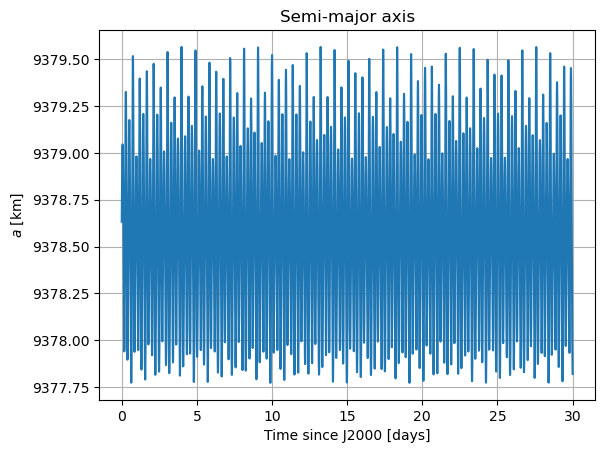

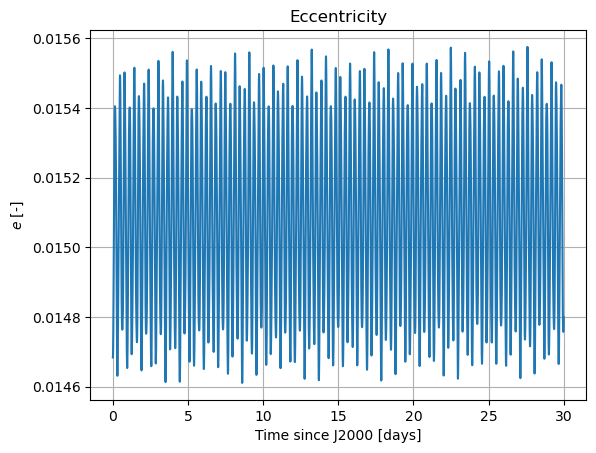

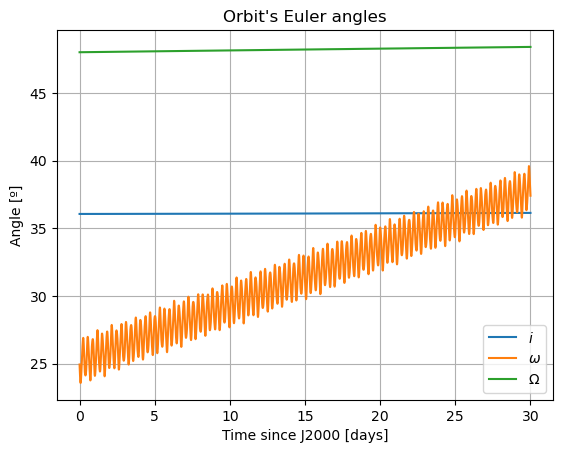

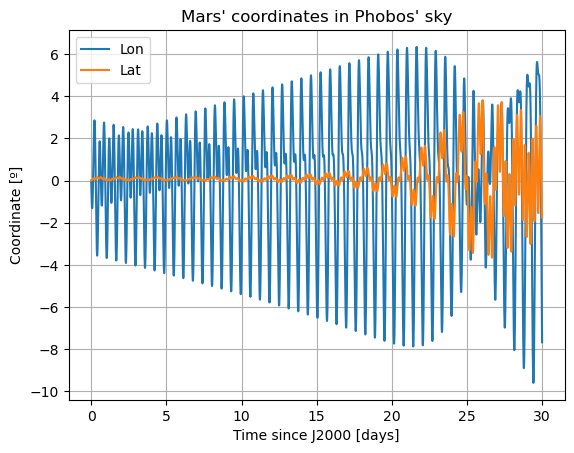

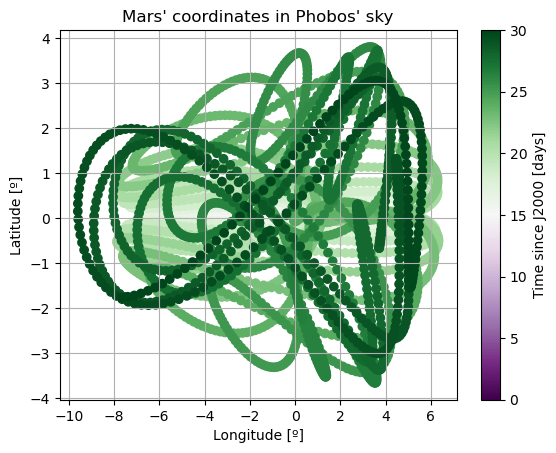

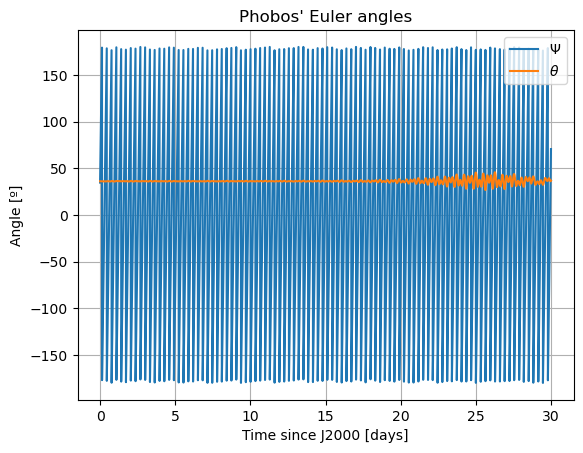

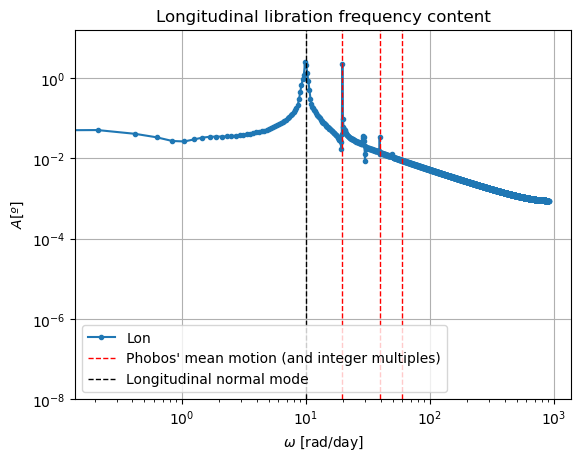

In [11]:
## PLOTS

# INDEX:      1,   2,   3,   4,     5,    6,     7,  8,   9,   10,     11,        12,        13
# STATE:      x,   y,   z,   vx,    vy,   vz,    q0, q1,  q2,  q3,     ang_vel_1, ang_vel_2, ang_vel_3
# DEPENDENTS: a,   e,   i,   omega, RAAN, theta, r,  lat, lon, euler3, euler1,    euler3

states_array = result2array(state_history)
dependents_array = result2array(dependent_variable_history)
epochs = states_array[:,0] / constants.JULIAN_DAY
time_label = 'Time since J2000 [days]'

plt.figure()
plt.plot(epochs, dependents_array[:,1] / 1e3)
plt.grid()
plt.xlabel(time_label)
plt.ylabel(r'$a$ [km]')
plt.title('Semi-major axis')

plt.figure()
plt.plot(epochs, dependents_array[:,2])
plt.grid()
plt.xlabel(time_label)
plt.ylabel(r'$e$ [-]')
plt.title('Eccentricity')

plt.figure()
plt.plot(epochs, np.degrees(dependents_array[:,3]), label = r'$i$')
plt.plot(epochs, np.degrees(dependents_array[:,4]), label = r'$\omega$')
plt.plot(epochs, np.degrees(dependents_array[:,5]), label = r'$\Omega$')
plt.grid()
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r'Angle [º]')
plt.title('Orbit\'s Euler angles')

plt.figure()
plt.plot(epochs, np.degrees(dependents_array[:,9]), label = r'Lon')
plt.plot(epochs, np.degrees(dependents_array[:,8]), label = r'Lat')
plt.grid()
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r'Coordinate [º]')
plt.title('Mars\' coordinates in Phobos\' sky')

cmap = plt.get_cmap('PRGn')
fig, axis = plt.subplots()
axis.scatter(np.degrees(dependents_array[:,9]), np.degrees(dependents_array[:,8]), c = epochs, cmap = cmap)
axis.grid()
axis.set_xlabel('Longitude [º]')
axis.set_ylabel('Latitude [º]')
axis.set_title('Mars\' coordinates in Phobos\' sky')
fig.colorbar(mappable=plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(epochs[0], epochs[-1])), ax=axis,
                 orientation='vertical', label=time_label)

plt.figure()
plt.plot(epochs, np.degrees(bring_inside_bounds(dependents_array[:,10], -PI, PI, include = 'upper')), label = r'$\Psi$')
plt.plot(epochs, np.degrees(dependents_array[:,11]), label = r'$\theta$')
plt.grid()
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r'Angle [º]')
plt.title('Phobos\' Euler angles')

mean_motion = 0.0002278563609852602
normal_mode = get_longitudinal_normal_mode_from_inertia_tensor(bodies.get('Phobos').inertia_tensor, mean_motion)
librations = bring_inside_bounds(dependents_array[:,8:10], -PI, PI, 'upper')
lon_lib_freq, lon_lib_amp = get_fourier(np.hstack((np.atleast_2d(dependents_array[:,0]).T, np.atleast_2d(librations[:,1]).T)), [2.0*PI, 1])
lat_lib_freq, lat_lib_amp = get_fourier(np.hstack((np.atleast_2d(dependents_array[:,0]).T, np.atleast_2d(librations[:,0]).T)), [2.0*PI, 1])
plt.figure()
plt.loglog(lon_lib_freq * 86400.0, np.degrees(lon_lib_amp), marker='.', label='Lon')
plt.gca().set_ylim(bottom=1e-8)
plt.axvline(mean_motion * 86400.0, ls='dashed', c='r', linewidth = 1.0, label='Phobos\' mean motion (and integer multiples)')
plt.axvline(normal_mode * 86400.0, ls='dashed', c='k', linewidth = 1.0, label='Longitudinal normal mode')
plt.axvline(2 * mean_motion * 86400.0, ls='dashed', c='r', linewidth = 1.0)
plt.axvline(3 * mean_motion * 86400.0, ls='dashed', c='r', linewidth = 1.0)
plt.title('Longitudinal libration frequency content')
plt.xlabel(r'$\omega$ [rad/day]')
plt.ylabel(r'$A [º]$')
plt.grid()
plt.legend()

plt.show()

**Note:** The third Euler angle of Phobos, $\varphi$, is omitted from plot. This is because it represents Phobos' rotation about its $z$ axis, and therefore it will increase secularly and overlap with $\Psi$.

Here, there are two things that immediately stand out: Mars' coordinates in Phobos' sky are a mess (i.e. Phobos' orientation is not what we expected) and the inclination of Phobos is nowhere near 0. We will start by addressing the latter. Notice that "the inclination of Phobos" is usually thought of as measured from the Martian equator. Here, however, the angles of the orbit are computed with respect to global frame orientation, which is here set to J2000. The Martian equator is inclined by about $35.5º$ with respect to that of the Earth, and that is why we see Phobos' inclination oscillate around that value rather than $0º$.

The reason behind the strange behaviour of Phobos' orientation is quite a bit lengthier. The rotational equations of motion presented at the beginning of this example, also known as Euler equations, give rise to non-zero periodic solutions even in the absence of any forcing (e.g. homogeneous solution). This means that, even when setting all torques to 0, Phobos' rotational motion will be oscillatory around all three axes. These solutions are called _proper modes_ or _normal modes_ and have a particular frequency associated to them - which is often times referred to as _normal mode_ as well. These are determined by Phobos' physical properties and the mean motion of its orbit. Although an in-depth discussion of normal modes will not be provided here - the interested reader is referred to (Rambaux et al. 2010).

In reality, Phobos' free modes have been damped due to dissipative effect. However, in the dynamics we have modelled in this example, this damping is not present, nor eas the initial state consistent with a damped situation, and therefore the normal modes will naturally arise. This can be very well seen in the frequency content of the longitudinal libration above, where a strong peak is observed at Phobos' proper mode. Thus, the _undamped_ dynamics we have simulated here is not realistic representation of Phobos' motion.

**Note:** If you are wondering why the FFT peak at the normal mode does not *exactly* coincide with the reference line, it is because this reference line has been computed with an approximate expression.

## Getting rid of the normal modes
As we just saw, Phobos does not rotate the way we would expect it to, due to the presence of excited normal modes. The fact that the normal mode is excited is a result of the initial rotational state, which is not consistent with rotational dynamics in which the normal modes are damped. We solve this problem by determining an initial state where these normal modes **are** damped, following the method used by (Rambaux et al. 2010). Specifically, we introduce a _virtual torque_ ("virtual" is a scientific word for "made up") that we know has a strong damping effect, and we propagate the dynamics forward in time. At one point, we will reach a state in which the normal modes have been eliminated from the dynamics (or 'damped'). Now, we remove this damping torque and we propagate the dynamics backward in time from this point onwards, until we reach our original initial time. This new rotational state that we have found, and will call the _damped initial state_ would ideally not excite the normal modes of Phobos when propagated forward again using our 'normal' (e.g. without the virtual torque) dynamical model.

In practice, the normal mode will be excited much less than initially, but some excitation still remains. This is further resolved by repeating the above procedure many times, with increasing 'damping times'. In Tudat, this approach is automated by the `get_damped_proper_mode_initial_rotational_state` function, see the [API reference](https://py.api.tudat.space/en/latest/propagation.html#tudatpy.numerical_simulation.propagation.get_damped_proper_mode_initial_rotational_state), where additional details of the algorithm are described. In short, a _damping time_ $\tau_{d}$ is selected, which is a measure of how quick the virtual torque will eliminate the normal modes, and it is used to compute the torque. The propagation is performed forwards in time with the virtual torque enabled, for $10 \tau_{d}$, and backwards to the original time without it. The new initial state is used in another iteration with a new and larger damping time. The implementation of the virtual torque in this algorithm is very specific to bodies in spin-orbit resonance, which will (averaged over long time periods) rotate uniformly around their body-fixed :math:`z` axis, with a period equal to the orbital period. The damping torque will act to prevent the excitation of the normal modes while preserving that uniform rotation. The function thus requires as inputs: (1) the `bodies` object, (2) the `propagator_settings` object, (3) the mean rotational rate of the body around its Z axis, and (4) a list of dissipation times or damping times in order to compute the virtual torques for the different iteration. The above is implemented as follows:

In [12]:
phobos_mean_rotational_rate = 0.000228035245  # In rad/s
# As dissipation times, we will start with 4h and keep duplicating the damping time in each iteration. In the final iteration, a damping time of 4096h means a propagation time of 40960h, which is a bit over 4.5 years.
dissipation_times = list(np.array([4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0, 2048.0, 4096.0])*3600.0)  # In seconds. Here, we
damping_results = numerical_simulation.propagation.get_damped_proper_mode_initial_rotational_state(bodies,
                                                                                         combined_propagator_settings,
                                                                                         phobos_mean_rotational_rate,
                                                                                         dissipation_times)
damped_state_history = damping_results.forward_backward_states[-1][1]
damped_dependent_variable_history = damping_results.forward_backward_dependent_variables[-1][1]

As you can see, we are using the `bodies` and the `propagator_settings` that we had already created earlier. The output of this function is the `damping_results` object, of type [TODO, insert link to class here]. This object contains:

- **The damped initial state.** This state is of the same type and size as the one provided in the `propagator_settings`. In this case of the coupled dynamics, a 13-dimensional vector. This is the initial state that the algorithm finds after its iterations, for which the normal modes should be (almost) entirely damped.
- **The forward-backward states.** It is a list of tuples. Each tuple contains the results of one iteration. In each of these tuples, there are two dictionaries: one of them is the state history of the forward propagation, i.e. with the damping torque; the other is the state history of the backward propagation, i.e. without the torque. There is one more tuple than iterations. The tuple in index 0 contains the undamped states, i.e. the histories of the forward and backward states when no torque is applied. **Note:** In this tuple, the two dictionaries are in principle the same, because the dynamics of both propagations are identical. The small errors that might be encountered are fully integration errors.
- **The forward-backward dependent variables.** It is the exact same thing as the forward-backward states, but with the dependent variables provided in the `propagator_settings`.

Notice that `damping_results` already contains the propagated states of the "fully" damped dynamics, which means there is no need to re-propagate them again with the obtained damped initial state. The damped trajectory is readily available to us, although it spans the 40960h of the final damping time. To aid in comparison with the undamped dynamics from above, we will only plot the first 30 days.

## Let's look at plots (again)
With the new damped states and dependent variables, we can perform the same kind of post-processing that we did earlier.

In these new damped dynamics, Mars does oscillate periodically around $0º$ of latitude and longitude in Phobos' sky, and the Fourier transform shows that the frequency at the normal mode is gone. Note that we would see the same thing in the FFT of Phobos' Euler angles. This is now a faithful representation of Phobos' motion. Note that, even though the libration at the frequency of the normal mode is removed, the fact that Phobos' normal mode is very close to its orbital period (strongest forcing frequency), there are numerous small forcing terms close to the normal mode that result in observable effects in Phobos' libration frequency spectrum. These are discussed and tabulated in detail by (Rambaux et al. 2010).

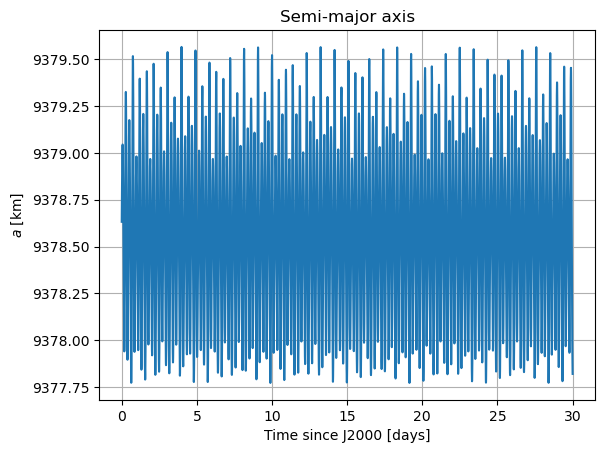

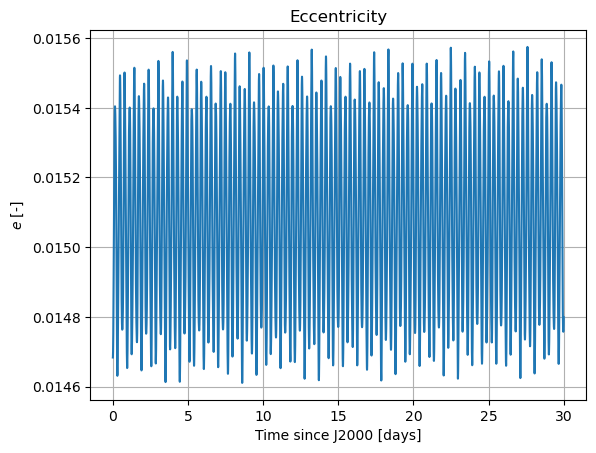

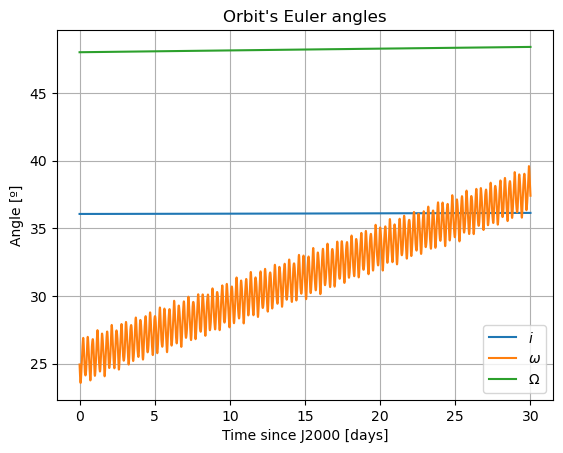

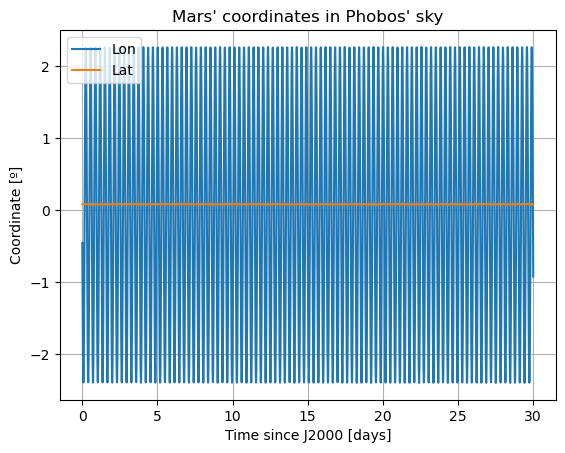

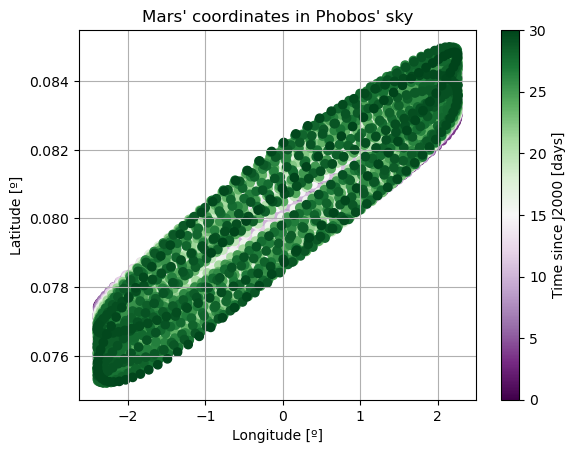

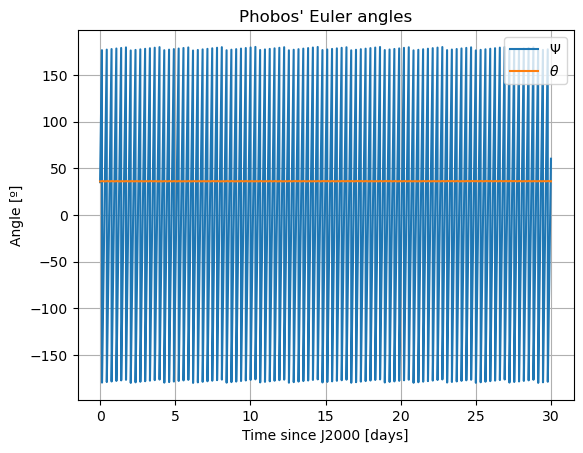

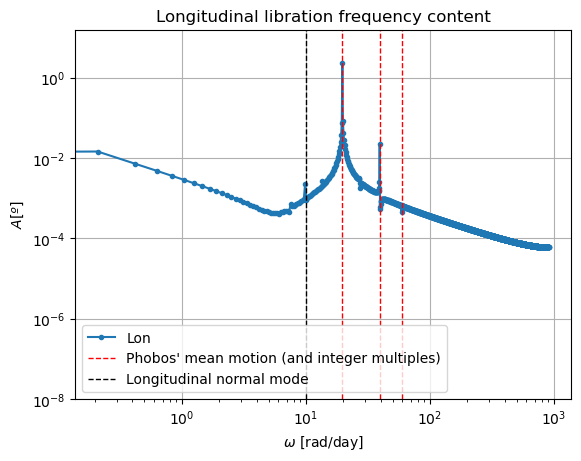

In [13]:
## PLOTS

# INDEX:      1,   2,   3,   4,     5,    6,     7,  8,   9,   10,     11,        12,        13
# STATE:      x,   y,   z,   vx,    vy,   vz,    q0, q1,  q2,  q3,     ang_vel_1, ang_vel_2, ang_vel_3
# DEPENDENTS: a,   e,   i,   omega, RAAN, theta, r,  lat, lon, euler3, euler1,    euler3

epochs_of_first_30_days = [epoch for epoch in list(state_history.keys()) if epoch <= 30.0*constants.JULIAN_DAY]
reduced_history = dict.fromkeys(epochs_of_first_30_days)
for epoch in epochs_of_first_30_days:
    reduced_history[epoch] = damped_state_history[epoch]
damped_states_array = result2array(reduced_history)
for epoch in epochs_of_first_30_days:
    reduced_history[epoch] = damped_dependent_variable_history[epoch]
damped_dependents_array = result2array(reduced_history)
epochs = damped_states_array[:,0] / constants.JULIAN_DAY
time_label = 'Time since J2000 [days]'

plt.figure()
plt.plot(epochs, damped_dependents_array[:,1] / 1e3)
plt.grid()
plt.xlabel(time_label)
plt.ylabel(r'$a$ [km]')
plt.title('Semi-major axis')

plt.figure()
plt.plot(epochs, damped_dependents_array[:,2])
plt.grid()
plt.xlabel(time_label)
plt.ylabel(r'$e$ [-]')
plt.title('Eccentricity')

plt.figure()
plt.plot(epochs, np.degrees(damped_dependents_array[:,3]), label = r'$i$')
plt.plot(epochs, np.degrees(damped_dependents_array[:,4]), label = r'$\omega$')
plt.plot(epochs, np.degrees(damped_dependents_array[:,5]), label = r'$\Omega$')
plt.grid()
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r'Angle [º]')
plt.title('Orbit\'s Euler angles')

plt.figure()
plt.plot(epochs, np.degrees(damped_dependents_array[:,9]), label = r'Lon')
plt.plot(epochs, np.degrees(damped_dependents_array[:,8]), label = r'Lat')
plt.grid()
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r'Coordinate [º]')
plt.title('Mars\' coordinates in Phobos\' sky')

cmap = plt.get_cmap('PRGn')
fig, axis = plt.subplots()
axis.scatter(np.degrees(damped_dependents_array[:,9]), np.degrees(damped_dependents_array[:,8]), c = epochs, cmap = cmap)
axis.grid()
axis.set_xlabel('Longitude [º]')
axis.set_ylabel('Latitude [º]')
axis.set_title('Mars\' coordinates in Phobos\' sky')
fig.colorbar(mappable=plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(epochs[0], epochs[-1])), ax=axis,
                 orientation='vertical', label=time_label)

plt.figure()
plt.plot(epochs, np.degrees(bring_inside_bounds(damped_dependents_array[:,10], -PI, PI, include = 'upper')), label = r'$\Psi$')
plt.plot(epochs, np.degrees(damped_dependents_array[:,11]), label = r'$\theta$')
# plt.plot(epochs, np.degrees(damped_dependents_array[:,12]), label = r'$\varphi$')
plt.grid()
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r'Angle [º]')
plt.title('Phobos\' Euler angles')

mean_motion = 0.0002278563609852602
normal_mode = get_longitudinal_normal_mode_from_inertia_tensor(bodies.get('Phobos').inertia_tensor, mean_motion)
damped_librations = bring_inside_bounds(damped_dependents_array[:,8:10], -PI, PI, 'upper')
damped_lon_lib_freq, damped_lon_lib_amp = get_fourier(np.hstack((np.atleast_2d(damped_dependents_array[:,0]).T, np.atleast_2d(damped_librations[:,1]).T)), [2.0*PI, 1])
damped_lat_lib_freq, damped_lat_lib_amp = get_fourier(np.hstack((np.atleast_2d(damped_dependents_array[:,0]).T, np.atleast_2d(damped_librations[:,0]).T)), [2.0*PI, 1])
plt.figure()
plt.loglog(damped_lon_lib_freq * 86400.0, np.degrees(damped_lon_lib_amp), marker='.', label='Lon')
# plt.loglog(lat_lib_freq * 86400.0, np.degrees(lat_lib_amp), marker='.', label='Lat')
plt.gca().set_ylim(bottom=1e-8)
plt.axvline(mean_motion * 86400.0, ls='dashed', c='r', linewidth = 1.0, label='Phobos\' mean motion (and integer multiples)')
plt.axvline(normal_mode * 86400.0, ls='dashed', c='k', linewidth = 1.0, label='Longitudinal normal mode')
plt.axvline(2 * mean_motion * 86400.0, ls='dashed', linewidth = 1.0, c='r')
plt.axvline(3 * mean_motion * 86400.0, ls='dashed', linewidth = 1.0, c='r')
plt.title('Longitudinal libration frequency content')
plt.xlabel(r'$\omega$ [rad/day]')
plt.ylabel(r'$A [º]$')
plt.grid()
plt.legend()

plt.show()